In [1]:
# %pip install joblib


In [2]:
# %pip install scikit-learn<0.23

In [3]:
# %pip install --upgrade numpy

In [4]:
# %pip show scikit-learn

In [5]:
#-----------------------------------
# TRAINING OUR MODEL
#-----------------------------------
import h5py  # Modul h5py untuk bekerja dengan file HDF5
import numpy as np  # Modul numpy untuk manipulasi array
import os  # Modul os untuk interaksi dengan sistem operasi
import glob  # Modul glob untuk pencarian pola nama file/path
import cv2  # Library OpenCV untuk manipulasi gambar
import warnings  # Modul warnings untuk mengabaikan peringatan
from matplotlib import pyplot  # Mengimpor pyplot dari matplotlib untuk visualisasi data
from sklearn.model_selection import train_test_split, cross_val_score  # Modul untuk pembagian data dan validasi silang
from sklearn.model_selection import KFold, StratifiedKFold  # Metode validasi silang K-Fold
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report  # Metrik evaluasi model
from sklearn.linear_model import LogisticRegression  # Model Regresi Logistik
from sklearn.tree import DecisionTreeClassifier  # Model Pohon Keputusan
from sklearn.ensemble import RandomForestClassifier  # Model Random Forest
from sklearn.neighbors import KNeighborsClassifier  # Model KNN
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis  # Model Analisis Diskriminan Linear
from sklearn.naive_bayes import GaussianNB  # Model Naive Bayes
from sklearn.svm import SVC  # Model Support Vector Machine
# from sklearn.externals import joblib  # Fungsi joblib untuk penyimpanan model
import joblib  # Modul joblib untuk penyimpanan model

warnings.filterwarnings('ignore')  # Mengabaikan peringatan yang muncul saat eksekusi kode


c:\Users\richa\anaconda3\lib\site-packages\scipy\__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.26.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


[STATUS] bentuk fitur: (1360, 532)
[STATUS] bentuk label: (1360,)
[STATUS] pelatihan dimulai...
[STATUS] membagi data latihan dan uji...
Data Latihan : (1224, 532)
Data Uji     : (136, 532)
Label Latihan: (1224,)
Label Uji    : (136,)
LR: 0.508130 (0.036337)
LDA: 0.429015 (0.040826)
KNN: 0.356144 (0.050514)
CART: 0.455031 (0.037149)
RF: 0.649514 (0.047277)
NB: 0.357817 (0.052014)
SVM: 0.506544 (0.045184)


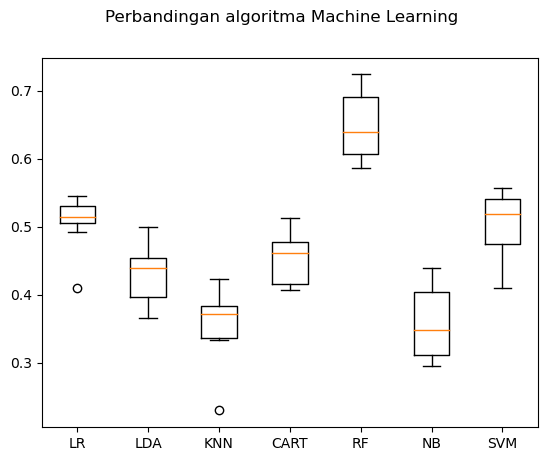

In [6]:

#--------------------
# parameter yang dapat diatur
#--------------------
num_trees = 100  # Jumlah pohon pada model Random Forest
test_size = 0.10  # Ukuran data uji dari keseluruhan data
seed      = 9  # Seed untuk pengacakan
train_path = "dataset/train"  # Path data latihan
test_path  = "dataset/test"  # Path data uji
h5_data    = 'output/data.h5'  # File untuk menyimpan data fitur
h5_labels  = 'output/labels.h5'  # File untuk menyimpan label
scoring    = "accuracy"  # Metrik evaluasi model

# Mendapatkan label pelatihan
train_labels=os.listdir(train_path)
# Mengurutkan label pelatihan
train_labels.sort()

if not os.path.exists(test_path):
    os.makedirs(test_path)

# Membuat semua model machine learning
models = []
models.append(('LR', LogisticRegression(random_state=seed)))  # Regresi Logistik
models.append(('LDA', LinearDiscriminantAnalysis()))  # Analisis Diskriminan Linear
models.append(('KNN', KNeighborsClassifier()))  # K-Nearest Neighbors (KNN)
models.append(('CART', DecisionTreeClassifier(random_state=seed)))  # Pohon Keputusan
models.append(('RF', RandomForestClassifier(n_estimators=num_trees, random_state=seed)))  # Random Forest
models.append(('NB', GaussianNB()))  # Naive Bayes
models.append(('SVM', SVC(random_state=seed)))  # Support Vector Machine (SVM)

# Variabel untuk menyimpan hasil dan nama model
results = []
names   = []

# Mengimpor vektor fitur dan label yang telah dilatih
h5f_data  = h5py.File(h5_data, 'r')
h5f_label = h5py.File(h5_labels, 'r')

global_features_string = h5f_data['dataset_1']
global_labels_string   = h5f_label['dataset_1']

global_features = np.array(global_features_string)
global_labels   = np.array(global_labels_string)

h5f_data.close()
h5f_label.close()

# Memeriksa bentuk vektor fitur dan label
print("[STATUS] bentuk fitur: {}".format(global_features.shape))
print("[STATUS] bentuk label: {}".format(global_labels.shape))

print("[STATUS] pelatihan dimulai...")

# Memisahkan data latihan dan uji
(trainDataGlobal, testDataGlobal, trainLabelsGlobal, testLabelsGlobal) = train_test_split(np.array(global_features),
                                                                                          np.array(global_labels),
                                                                                          test_size=test_size,
                                                                                          random_state=seed)

print("[STATUS] membagi data latihan dan uji...")
print("Data Latihan : {}".format(trainDataGlobal.shape))
print("Data Uji     : {}".format(testDataGlobal.shape))
print("Label Latihan: {}".format(trainLabelsGlobal.shape))
print("Label Uji    : {}".format(testLabelsGlobal.shape))

# Validasi silang 10-fold
for name, model in models:
    kfold = KFold(n_splits=10, shuffle=True, random_state=seed)
    cv_results = cross_val_score(model, trainDataGlobal, trainLabelsGlobal, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

# diagram boxplot perbandingan algoritma machine learning
fig = pyplot.figure()
fig.suptitle('Perbandingan algoritma Machine Learning')
ax = fig.add_subplot(111)
pyplot.boxplot(results)
ax.set_xticklabels(names)
pyplot.show()


In [7]:
from myglobal import fixed_size  # Mengimpor variabel fixed_size dari file myglobal
from myglobal import fd_hu_moments  # Mengimpor fungsi fd_hu_moments dari file myglobal
from myglobal import fd_haralick  # Mengimpor fungsi fd_haralick dari file myglobal
from myglobal import fd_histogram  # Mengimpor fungsi fd_histogram dari file myglobal


['bluebell', 'buttercup', 'coltsfoot', 'cowslip', 'crocus', 'daffodil', 'daisy', 'dandelion', 'fritillary', 'iris', 'lilyvalley', 'pansy', 'snowdrop', 'sunflower', 'tigerlily', 'tulip', 'windflower']
[STATUS] processed folder: bluebell
[STATUS] processed folder: buttercup
[STATUS] processed folder: coltsfoot
[STATUS] processed folder: cowslip
[STATUS] processed folder: crocus
[STATUS] processed folder: daffodil
[STATUS] processed folder: daisy
[STATUS] processed folder: dandelion
[STATUS] processed folder: fritillary
[STATUS] processed folder: iris
[STATUS] processed folder: lilyvalley
[STATUS] processed folder: pansy
[STATUS] processed folder: snowdrop
[STATUS] processed folder: sunflower
[STATUS] processed folder: tigerlily
[STATUS] processed folder: tulip
[STATUS] processed folder: windflower
[STATUS] completed Global Feature Extraction...
[STATUS] feature vector size (1360, 532)
[STATUS] training Labels (1360,)
[STATUS] training labels encoded...
[STATUS] feature vector normalized.

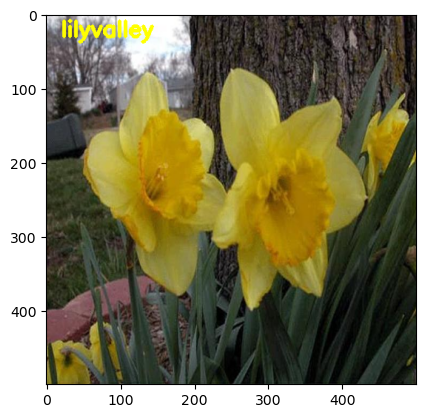

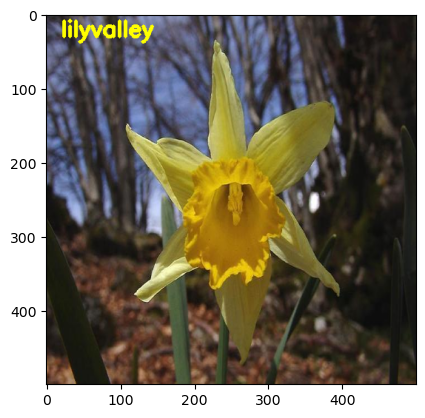

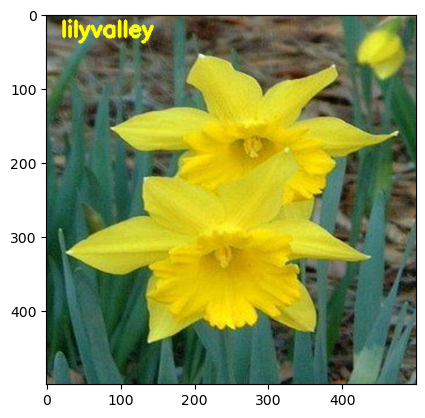

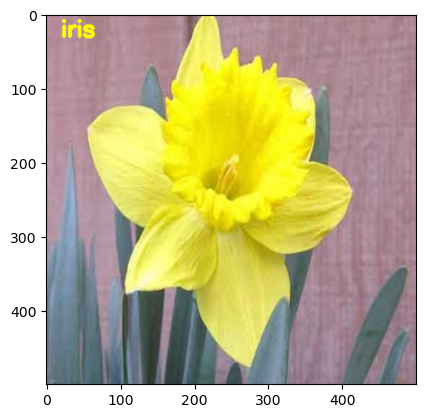

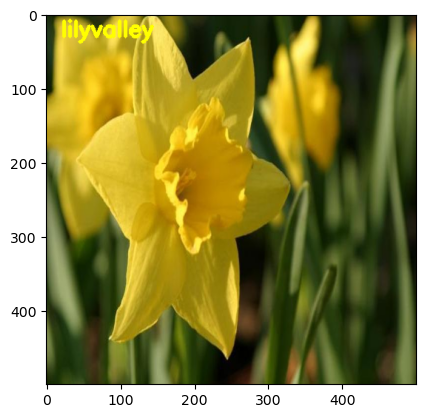

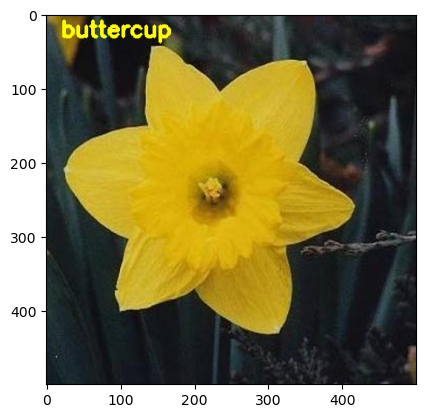

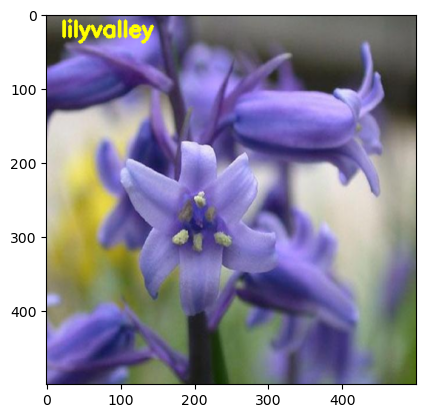

In [8]:
#-----------------------------------
# MENGUJI MODEL KAMI
#-----------------------------------

# untuk visualisasi hasil
import matplotlib.pyplot as plt  # Mengimpor pyplot dari matplotlib untuk visualisasi

from sklearn.preprocessing import MinMaxScaler  # Mengimpor MinMaxScaler dari sklearn untuk penskalaan fitur

# membuat model - Random Forests
clf  = RandomForestClassifier(n_estimators=num_trees, random_state=seed)

# melatih data latihan pada model
clf.fit(trainDataGlobal, trainLabelsGlobal)

# path uji = 'dataset/train/bluebell/'

# perulangan melalui gambar-gambar uji
for file in glob.glob(test_path + "/*.jpg"):
    # membaca gambar
    image = cv2.imread(file)
    # image = cv2.imread(dataset/)

    # mengubah ukuran gambar
    image = cv2.resize(image, fixed_size)

    ####################################
    # Ekstraksi Fitur Global
    ####################################
    fv_hu_moments = fd_hu_moments(image)
    fv_haralick   = fd_haralick(image)
    fv_histogram  = fd_histogram(image)

    ###################################
    # Menggabungkan fitur global
    ###################################
    global_feature = np.hstack([fv_histogram, fv_haralick, fv_hu_moments])

    # penskalaan fitur dalam rentang (0-1)
    scaler = MinMaxScaler(feature_range=(0, 1))
    # fitur yang telah penskalaan = scaler.fit_transform(global_feature)
    fitur_diskala_ulang = scaler.fit_transform(global_feature.reshape(-1, 1))

    # prediksi label gambar uji
    prediksi = clf.predict(fitur_diskala_ulang.reshape(1,-1))[0]

    # menampilkan label prediksi pada gambar
    cv2.putText(image, train_labels[prediksi], (20,30), cv2.FONT_HERSHEY_SIMPLEX, 1.0, (0,255,255), 3)

    # menampilkan gambar output
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.show()
